In [1]:
using DataFrames, Dates, Plots, CSV, DataFramesMeta, MLJ, StatsPlots, LaTeXStrings, DifferentialEquations
using Turing
using LazyArrays
using Random: seed!

In [2]:
function data_processing(country::String)
    data = CSV.read("../data/confirmed_cases_global.csv", DataFrame)
    rename!(data, 1 => "province", 2 => "country")
    countries = collect(data[:, 2])
    row = findfirst(countries .== country)
    data_row = data[row, :]
    country_data = [i for i in values(data_row[5:end])]
    
    date_strings =String.(names(data))[5:end]
    format = Dates.DateFormat("m/d/Y")
    dates = parse.(Date, date_strings, format) + Year(2000)

    df = DataFrame(confirmed = country_data, dates = dates)    
    return df
end

data_processing (generic function with 1 method)

In [3]:
start_date = Date(2020,03,01);
end_date = Date(2020,12,01);

In [4]:
ng_data = data_processing("Nigeria");

# ng_filtered = @subset(ng_data, :confirmed .> 0)

Row,confirmed,dates
,Int64,Date
1,0,2020-01-22
2,0,2020-01-23
3,0,2020-01-24
4,0,2020-01-25
5,0,2020-01-26
6,0,2020-01-27
7,0,2020-01-28
8,0,2020-01-29
9,0,2020-01-30


In [5]:
# range_data = ng_filtered[2,start_date:end_date]

ng = filter(row -> start_date <= row.dates <= end_date, ng_data)

Row,confirmed,dates
,Int64,Date
1,1,2020-03-01
2,1,2020-03-02
3,1,2020-03-03
4,1,2020-03-04
5,1,2020-03-05
6,1,2020-03-06
7,1,2020-03-07
8,1,2020-03-08
9,2,2020-03-09


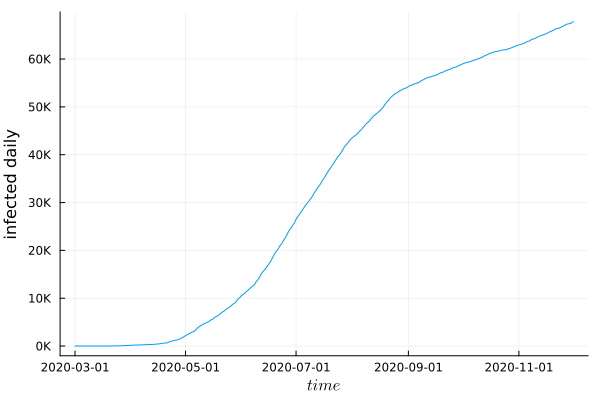

In [6]:
@df ng plot(:dates,
    :confirmed,
    xlab=L"time", ylab="infected daily",
    yformatter=y -> string(round(Int64, y ÷ 1_000)) * "K",
    label=false)

In [7]:
# function seir_ode!(du, u, p, t)
#     (S, E, I, R) = u
#     (β, γ) = p
#     N = S + I + R
#     infection = β * I * S / N
#     exposed = γ * E
#     recovery = γ * I
#     @inbounds begin
#         du[1] = -infection # Susceptible
#         du[2] = infection - exposed # Exposed
#         du[2] = exposed - recovery # Infected
#         du[3] = recovery # Recovered
#     end
#     nothing
# end;

using DifferentialEquations

function sir_ode!(du, u, p, t)
    (S, I, R) = u
    (β, γ) = p
    N = S + I + R
    infection = β * I * S / N
    recovery = γ * I
    @inbounds begin
        du[1] = -infection # Susceptible
        du[2] = infection - recovery # Infected
        du[3] = recovery # Recovered
    end
    nothing
end;

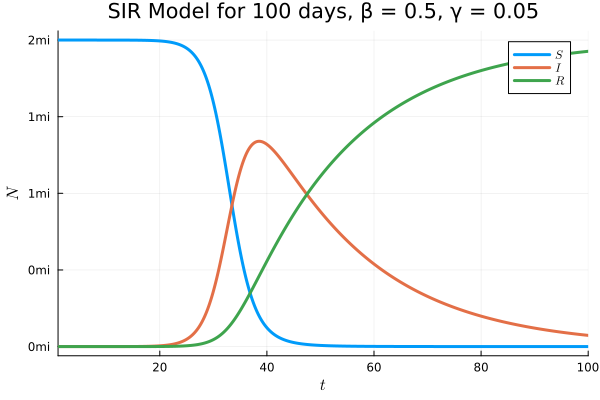

In [8]:
# i₀ = first(ng[:, :confirmed])
# N = last(ng[:, :confirmed])
# e₀ = 100

# u = [N - e₀ - i₀, e₀, i₀, 0.0]
# p = [0.5, 0.1]
# prob = ODEProblem(sir_ode!, u, (1.0, 100.0), p)
# sol_ode = solve(prob)
# plot(sol_ode, label=[L"S" L"E" L"I" L"R"],
#     lw=4,
#     xlabel=L"t",
#     ylabel=L"N",
#     yformatter=y -> string(round(Int64, y ÷ 1_000_000)) * "mi",
#     title="SEIR Model for 100 days, β = $(p[1]), γ = $(p[2])")

i₀ = first(ng[:, :confirmed])
N = 2000000

u = [N - i₀, i₀, 0.0]
p = [0.5, 0.05]
prob = ODEProblem(sir_ode!, u, (1.0, 100.0), p)
sol_ode = solve(prob)
plot(sol_ode, label=[L"S" L"I" L"R"],
    lw=3,
    xlabel=L"t",
    ylabel=L"N",
    yformatter=y -> string(round(Int64, y ÷ 1_000_000)) * "mi",
    title="SIR Model for 100 days, β = $(p[1]), γ = $(p[2])")

In [9]:
function NegativeBinomial2(μ, ϕ)
    p = 1 / (1 + μ / ϕ)
    r = ϕ

    return NegativeBinomial(r, p)
end

NegativeBinomial2 (generic function with 1 method)

In [10]:
seed!(123)

@model function bayes_sir(infected, i₀, r₀, N)
    #calculate number of timepoints
    l = length(infected)

    #priors
    β ~ TruncatedNormal(2, 1, 1e-4, 10)     # using 10 because numerical issues arose
    γ ~ TruncatedNormal(0.4, 0.5, 1e-4, 10) # using 10 because numerical issues arose
    ϕ⁻ ~ truncated(Exponential(5); lower=0, upper=1e5)
    ϕ = 1.0 / ϕ⁻

    #ODE Stuff
    I = i₀
    u0 = [N - I, I, r₀] # S,I,R
    p = [β, γ]
    tspan = (1.0, float(l))
    prob = ODEProblem(sir_ode!,
        u0,
        tspan,
        p)
    sol = solve(prob,
        Tsit5(), # similar to Dormand-Prince RK45 in Stan but 20% faster
        saveat=1.0)
    solᵢ = Array(sol)[2, :] # New Infected
    solᵢ = max.(1e-4, solᵢ) # numerical issues arose

    #likelihood
    infected ~ arraydist(LazyArray(@~ NegativeBinomial2.(solᵢ, ϕ)))
end;

In [11]:
infected = ng[:, :confirmed]
r₀ = 1
model_sir = bayes_sir(infected, i₀, r₀, N)
chain_sir = sample(model_sir, NUTS(), 1_000)
summarystats(chain_sir[[:β, :γ]])

Sampling   0%|█                                         |  ETA: N/A
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


┌ Info: Found initial step size
│   ϵ = 0.00625
└ @ Turing.Inference C:\Users\ajaoo\.julia\packages\Turing\dl9my\src\inference\hmc.jl:191


┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47


Sampling   0%|█                                         |  ETA: 1:18:51
Sampling   1%|█                                         |  ETA: 0:39:19
Sampling   1%|█                                         |  ETA: 0:26:06
Sampling   2%|█                                         |  ETA: 0:19:30
Sampling   2%|█                                         |  ETA: 0:15:32
Sampling   3%|██                                        |  ETA: 0:12:54


Sampling   3%|██                                        |  ETA: 0:11:00
Sampling   4%|██                                        |  ETA: 0:09:35
Sampling   4%|██                                        |  ETA: 0:08:29
Sampling   5%|██                                        |  ETA: 0:07:36
Sampling   5%|███                                       |  ETA: 0:06:53
Sampling   6%|███                                       |  ETA: 0:06:16
Sampling   6%|███                                       |  ETA: 0:05:46
Sampling   7%|███                                       |  ETA: 0:05:20
Sampling   7%|███                                       |  ETA: 0:04:57
Sampling   7%|████                                      |  ETA: 0:04:37


Sampling   8%|████                                      |  ETA: 0:04:20
Sampling   8%|████                                      |  ETA: 0:04:04
Sampling   9%|████                                      |  ETA: 0:03:50
Sampling   9%|████                                      |  ETA: 0:03:38
Sampling  10%|█████                                     |  ETA: 0:03:27
Sampling  10%|█████                                     |  ETA: 0:03:16
Sampling  11%|█████                                     |  ETA: 0:03:07
Sampling  11%|█████                                     |  ETA: 0:02:58
Sampling  12%|█████                                     |  ETA: 0:02:50
Sampling  12%|██████                                    |  ETA: 0:02:43
Sampling  13%|██████                                    |  ETA: 0:02:36
Sampling  13%|██████                                    |  ETA: 0:02:30


Sampling  14%|██████                                    |  ETA: 0:02:24
Sampling  14%|██████                                    |  ETA: 0:02:18
Sampling  14%|███████                                   |  ETA: 0:02:13
Sampling  15%|███████                                   |  ETA: 0:02:08
Sampling  15%|███████                                   |  ETA: 0:02:04


Sampling  16%|███████                                   |  ETA: 0:02:00
Sampling  16%|███████                                   |  ETA: 0:01:56


Sampling  17%|████████                                  |  ETA: 0:01:53
Sampling  17%|████████                                  |  ETA: 0:01:50


Sampling  18%|████████                                  |  ETA: 0:01:47


Sampling  18%|████████                                  |  ETA: 0:01:44


Sampling  19%|████████                                  |  ETA: 0:01:42
Sampling  19%|█████████                                 |  ETA: 0:01:39
Sampling  20%|█████████                                 |  ETA: 0:01:36
Sampling  20%|█████████                                 |  ETA: 0:01:33
Sampling  21%|█████████                                 |  ETA: 0:01:31
Sampling  21%|█████████                                 |  ETA: 0:01:28
Sampling  21%|██████████                                |  ETA: 0:01:26
Sampling  22%|██████████                                |  ETA: 0:01:24


Sampling  22%|██████████                                |  ETA: 0:01:21
Sampling  23%|██████████                                |  ETA: 0:01:19
Sampling  23%|██████████                                |  ETA: 0:01:17
Sampling  24%|██████████                                |  ETA: 0:01:15
Sampling  24%|███████████                               |  ETA: 0:01:14
Sampling  25%|███████████                               |  ETA: 0:01:12
Sampling  25%|███████████                               |  ETA: 0:01:10
Sampling  26%|███████████                               |  ETA: 0:01:08


Sampling  26%|███████████                               |  ETA: 0:01:07
Sampling  27%|████████████                              |  ETA: 0:01:05
Sampling  27%|████████████                              |  ETA: 0:01:04
Sampling  28%|████████████                              |  ETA: 0:01:02
Sampling  28%|████████████                              |  ETA: 0:01:01
Sampling  28%|████████████                              |  ETA: 0:01:00
Sampling  29%|█████████████                             |  ETA: 0:00:58


Sampling  29%|█████████████                             |  ETA: 0:00:57
Sampling  30%|█████████████                             |  ETA: 0:00:56
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
┌ Warning: The current proposal will be rejected due to numerical error(s).
│   isfinite.((θ, r, ℓπ, ℓκ)) = (true, false, false, false)
└ @ AdvancedHMC C:\Users\ajaoo\.julia\packages\AdvancedHMC\iWHPQ\src\hamiltonian.jl:47
Sampling  30%|█████████████                             |  ETA: 0:00:55
Sampling  31%|█████████████                             |  ETA: 0:00:53
Sampling  31%|██████████████              


Sampling  32%|██████████████                            |  ETA: 0:00:51
Sampling  32%|██████████████                            |  ETA: 0:00:50
Sampling  33%|██████████████                            |  ETA: 0:00:49
Sampling  33%|██████████████                            |  ETA: 0:00:48
Sampling  34%|███████████████                           |  ETA: 0:00:47
Sampling  34%|███████████████                           |  ETA: 0:00:46
Sampling  35%|███████████████                           |  ETA: 0:00:45
Sampling  35%|███████████████                           |  ETA: 0:00:44
Sampling  35%|███████████████                           |  ETA: 0:00:44
Sampling  36%|████████████████                          |  ETA: 0:00:43


Sampling  36%|████████████████                          |  ETA: 0:00:42
Sampling  37%|████████████████                          |  ETA: 0:00:41
Sampling  37%|████████████████                          |  ETA: 0:00:40
Sampling  38%|████████████████                          |  ETA: 0:00:39
Sampling  38%|█████████████████                         |  ETA: 0:00:39
Sampling  39%|█████████████████                         |  ETA: 0:00:38
Sampling  39%|█████████████████                         |  ETA: 0:00:37
Sampling  40%|█████████████████                         |  ETA: 0:00:37
Sampling  40%|█████████████████                         |  ETA: 0:00:36
Sampling  41%|██████████████████                        |  ETA: 0:00:35
Sampling  41%|██████████████████                        |  ETA: 0:00:34
Sampling  42%|██████████████████                        |  ETA: 0:00:34


Sampling  42%|██████████████████                        |  ETA: 0:00:33
Sampling  42%|██████████████████                        |  ETA: 0:00:33
Sampling  43%|███████████████████                       |  ETA: 0:00:32
Sampling  43%|███████████████████                       |  ETA: 0:00:31
Sampling  44%|███████████████████                       |  ETA: 0:00:31
Sampling  44%|███████████████████                       |  ETA: 0:00:30
Sampling  45%|███████████████████                       |  ETA: 0:00:30
Sampling  45%|████████████████████                      |  ETA: 0:00:29
Sampling  46%|████████████████████                      |  ETA: 0:00:29
Sampling  46%|████████████████████                      |  ETA: 0:00:28
Sampling  47%|████████████████████                      |  ETA: 0:00:28


Sampling  47%|████████████████████                      |  ETA: 0:00:27
Sampling  48%|████████████████████                      |  ETA: 0:00:27
Sampling  48%|█████████████████████                     |  ETA: 0:00:26
Sampling  49%|█████████████████████                     |  ETA: 0:00:26
Sampling  49%|█████████████████████                     |  ETA: 0:00:25
Sampling  49%|█████████████████████                     |  ETA: 0:00:25
Sampling  50%|█████████████████████                     |  ETA: 0:00:24
Sampling  50%|██████████████████████                    |  ETA: 0:00:24
Sampling  51%|██████████████████████                    |  ETA: 0:00:23
Sampling  51%|██████████████████████                    |  ETA: 0:00:23


Sampling  52%|██████████████████████                    |  ETA: 0:00:23
Sampling  52%|██████████████████████                    |  ETA: 0:00:22
Sampling  53%|███████████████████████                   |  ETA: 0:00:22
Sampling  53%|███████████████████████                   |  ETA: 0:00:21
Sampling  54%|███████████████████████                   |  ETA: 0:00:21
Sampling  54%|███████████████████████                   |  ETA: 0:00:21
Sampling  55%|███████████████████████                   |  ETA: 0:00:20
Sampling  55%|████████████████████████                  |  ETA: 0:00:20
Sampling  56%|████████████████████████                  |  ETA: 0:00:19
Sampling  56%|████████████████████████                  |  ETA: 0:00:19


Sampling  56%|████████████████████████                  |  ETA: 0:00:19
Sampling  57%|████████████████████████                  |  ETA: 0:00:18
Sampling  57%|█████████████████████████                 |  ETA: 0:00:18
Sampling  58%|█████████████████████████                 |  ETA: 0:00:18
Sampling  58%|█████████████████████████                 |  ETA: 0:00:17
Sampling  59%|█████████████████████████                 |  ETA: 0:00:17
Sampling  59%|█████████████████████████                 |  ETA: 0:00:17
Sampling  60%|██████████████████████████                |  ETA: 0:00:16
Sampling  60%|██████████████████████████                |  ETA: 0:00:16
Sampling  61%|██████████████████████████                |  ETA: 0:00:16


Sampling  61%|██████████████████████████                |  ETA: 0:00:16
Sampling  62%|██████████████████████████                |  ETA: 0:00:15
Sampling  62%|███████████████████████████               |  ETA: 0:00:15
Sampling  63%|███████████████████████████               |  ETA: 0:00:15
Sampling  63%|███████████████████████████               |  ETA: 0:00:14
Sampling  63%|███████████████████████████               |  ETA: 0:00:14


Sampling  64%|███████████████████████████               |  ETA: 0:00:14
Sampling  64%|████████████████████████████              |  ETA: 0:00:14
Sampling  65%|████████████████████████████              |  ETA: 0:00:13
Sampling  65%|████████████████████████████              |  ETA: 0:00:13
Sampling  66%|████████████████████████████              |  ETA: 0:00:13
Sampling  66%|████████████████████████████              |  ETA: 0:00:13
Sampling  67%|█████████████████████████████             |  ETA: 0:00:12
Sampling  67%|█████████████████████████████             |  ETA: 0:00:12
Sampling  68%|█████████████████████████████             |  ETA: 0:00:12
Sampling  68%|█████████████████████████████             |  ETA: 0:00:12
Sampling  69%|█████████████████████████████             |  ETA: 0:00:11
Sampling  69%|██████████████████████████████            |  ETA: 0:00:11


Sampling  70%|██████████████████████████████            |  ETA: 0:00:11
Sampling  70%|██████████████████████████████            |  ETA: 0:00:11
Sampling  70%|██████████████████████████████            |  ETA: 0:00:10
Sampling  71%|██████████████████████████████            |  ETA: 0:00:10
Sampling  71%|██████████████████████████████            |  ETA: 0:00:10
Sampling  72%|███████████████████████████████           |  ETA: 0:00:10
Sampling  72%|███████████████████████████████           |  ETA: 0:00:09
Sampling  73%|███████████████████████████████           |  ETA: 0:00:09
Sampling  73%|███████████████████████████████           |  ETA: 0:00:09
Sampling  74%|███████████████████████████████           |  ETA: 0:00:09
Sampling  74%|████████████████████████████████          |  ETA: 0:00:09
Sampling  75%|████████████████████████████████          |  ETA: 0:00:08


Sampling  75%|████████████████████████████████          |  ETA: 0:00:08
Sampling  76%|████████████████████████████████          |  ETA: 0:00:08
Sampling  76%|████████████████████████████████          |  ETA: 0:00:08
Sampling  77%|█████████████████████████████████         |  ETA: 0:00:08
Sampling  77%|█████████████████████████████████         |  ETA: 0:00:07
Sampling  77%|█████████████████████████████████         |  ETA: 0:00:07
Sampling  78%|█████████████████████████████████         |  ETA: 0:00:07
Sampling  78%|█████████████████████████████████         |  ETA: 0:00:07
Sampling  79%|██████████████████████████████████        |  ETA: 0:00:07
Sampling  79%|██████████████████████████████████        |  ETA: 0:00:06
Sampling  80%|██████████████████████████████████        |  ETA: 0:00:06


Sampling  80%|██████████████████████████████████        |  ETA: 0:00:06
Sampling  81%|██████████████████████████████████        |  ETA: 0:00:06
Sampling  81%|███████████████████████████████████       |  ETA: 0:00:06
Sampling  82%|███████████████████████████████████       |  ETA: 0:00:06
Sampling  82%|███████████████████████████████████       |  ETA: 0:00:05
Sampling  83%|███████████████████████████████████       |  ETA: 0:00:05
Sampling  83%|███████████████████████████████████       |  ETA: 0:00:05
Sampling  84%|████████████████████████████████████      |  ETA: 0:00:05
Sampling  84%|████████████████████████████████████      |  ETA: 0:00:05
Sampling  84%|████████████████████████████████████      |  ETA: 0:00:05
Sampling  85%|████████████████████████████████████      |  ETA: 0:00:04
Sampling  85%|████████████████████████████████████      |  ETA: 0:00:04


Sampling  86%|█████████████████████████████████████     |  ETA: 0:00:04
Sampling  86%|█████████████████████████████████████     |  ETA: 0:00:04
Sampling  87%|█████████████████████████████████████     |  ETA: 0:00:04
Sampling  87%|█████████████████████████████████████     |  ETA: 0:00:04
Sampling  88%|█████████████████████████████████████     |  ETA: 0:00:03
Sampling  88%|██████████████████████████████████████    |  ETA: 0:00:03
Sampling  89%|██████████████████████████████████████    |  ETA: 0:00:03
Sampling  89%|██████████████████████████████████████    |  ETA: 0:00:03
Sampling  90%|██████████████████████████████████████    |  ETA: 0:00:03
Sampling  90%|██████████████████████████████████████    |  ETA: 0:00:03
Sampling  91%|███████████████████████████████████████   |  ETA: 0:00:03
Sampling  91%|███████████████████████████████████████   |  ETA: 0:00:02


Sampling  91%|███████████████████████████████████████   |  ETA: 0:00:02
Sampling  92%|███████████████████████████████████████   |  ETA: 0:00:02
Sampling  92%|███████████████████████████████████████   |  ETA: 0:00:02
Sampling  93%|████████████████████████████████████████  |  ETA: 0:00:02
Sampling  93%|████████████████████████████████████████  |  ETA: 0:00:02
Sampling  94%|████████████████████████████████████████  |  ETA: 0:00:02
Sampling  94%|████████████████████████████████████████  |  ETA: 0:00:02
Sampling  95%|████████████████████████████████████████  |  ETA: 0:00:

01
Sampling  95%|████████████████████████████████████████  |  ETA: 0:00:01
Sampling  96%|█████████████████████████████████████████ |  ETA: 0:00:01
Sampling  96%|█████████████████████████████████████████ |  ETA: 0:00:01
Sampling  97%|█████████████████████████████████████████ |  ETA: 0:00:01
Sampling  97%|█████████████████████████████████████████ |  ETA: 0:00:01
Sampling  98%|█████████████████████████████████████████ |  ETA: 0:00:01
Sampling  98%|██████████████████████████████████████████|  ETA: 0:00:01
Sampling  98%|██████████████████████████████████████████|  ETA: 0:00:00
Sampling  99%|██████████████████████████████████████████|  ETA: 0:00:00
Sampling  99%|██████████████████████████████████████████|  ETA: 0:00:00
Sampling 100%|██████████████████████████████████████████|  ETA: 0:00:00


Sampling 100%|██████████████████████████████████████████| Time: 0:00:25

Summary Statistics
  parameters      mean       std   naive_se      mcse         ess      rhat    ⋯
      Symbol   Float64   Float64    Float64   Float64     Float64   Float64    ⋯

           β    0.1498    0.0022     0.0001    0.0001   1566.0065    0.9990    ⋯
           γ    0.0318    0.0015     0.0000    0.0001    284.9547    0.9991    ⋯
                                                                1 column omitted


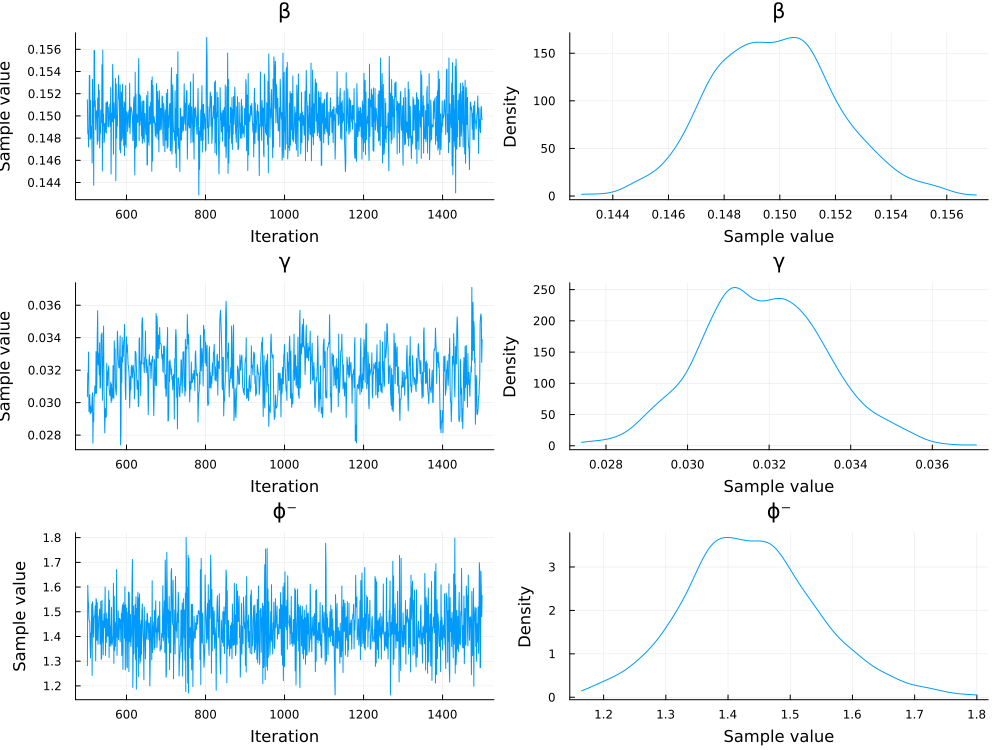

In [12]:
plot(chain_sir)

In [13]:
@model bayes_sir(infected) = begin
    # Calculate number of timepoints
    l = length(infected)
    i₀  ~ Uniform(0,10)
    β ~ Uniform(0,10)
    γ ~ Uniform(0,10)
    u0=[N - i₀,i₀,0.0,]
    p=[β,10.0,0.25]
    tspan = (0.0,float(l))
    prob = ODEProblem(sir_ode!,
            u0,
            tspan,
            p)
    sol = solve(prob,
                Tsit5(),
                saveat = 1.0)
    sol_C = Array(sol)[4,:] # Cumulative cases
    sol_X = sol_C[2:end] - sol_C[1:(end-1)]
    l = length(infected)
    for i in 1:l
      infected[i] ~ Poisson(sol_X[i])
    end
  end;

In [14]:
ode_nuts = sample(bayes_sir(infected),NUTS(0.65),10000);

Sampling   0%|█                                         |  ETA: N/A
Sampling 100%|██████████████████████████████████████████| Time: 0:00:00


BoundsError: BoundsError: attempt to access 3×277 Matrix{Float64} at index [4, 1:277]

In [15]:
describe(ode_nuts)

UndefVarError: UndefVarError: ode_nuts not defined

In [16]:
plot(ode_nuts)

UndefVarError: UndefVarError: ode_nuts not defined

In [17]:
seed!(123)

@model function bayes_sir(infected, i₀, r₀, N)
    #calculate number of timepoints
    l = length(infected)

    #priors
    β ~ TruncatedNormal(2, 1, 1e-4, 10)     # using 10 because numerical issues arose
    γ ~ TruncatedNormal(0.4, 0.5, 1e-4, 10) # using 10 because numerical issues arose
    ϕ⁻ ~ truncated(Exponential(5); lower=0, upper=1e5)
    ϕ = 1.0 / ϕ⁻

    #ODE Stuff
    I = i₀
    u0 = [N - I, I, r₀] # S,I,R
    p = [β, γ]
    tspan = (1.0, float(l))
    prob = ODEProblem(sir_ode!,
        u0,
        tspan,
        p)
    sol = solve(prob,
        Tsit5(), # similar to Dormand-Prince RK45 in Stan but 20% faster
        saveat=1.0)
    solᵢ = Array(sol)[2, :] # New Infected
    solᵢ = max.(1e-4, solᵢ) # numerical issues arose

    #likelihood
    infected ~ arraydist(LazyArray(@~ NegativeBinomial2.(solᵢ, ϕ)))
end;

Consider a country that is currently facing a pandemic. The country is divided into different regions, and each region has a certain population that is in need of a vaccine. The government wants to allocate the available vaccines among the regions in a way that maximizes the number of people who are protected from the disease.

At each period during the pandemic, the government receives a certain number of vaccines that it can distribute among the regions. The goal is to find an optimal allocation of vaccines that maximizes the number of people who are protected from the disease at each period.

The optimization problem can be formulated as follows:

Maximize:
$\sum_{t=1}^{T} \sum_{i=1}^{N} x_{i,t}$

Subject to:

$\sum_{i=1}^{N} x_{i,t} \leq V_t \quad \forall t \in [1, T]$

$x_{i,t} \leq P_{i,t} \quad \forall i \in [1, N], \forall t \in [1, T]$

$x_{i,t} \geq 0 \quad \forall i \in [1, N], \forall t \in [1, T]$

where:

$T$ is the total number of periods during the pandemic.

$N$ is the number of regions in the country.

$V_t$ is the number of vaccines available at period $t$.

$P_{i,t}$ is the population of region $i$ at period $t$.

$x_{i,t}$ is the number of vaccines that are allocated to region $i$ at period $t$.

The objective function seeks to maximize the total number of people who are protected from the disease by allocating the available vaccines among the regions. The first constraint ensures that the number of vaccines allocated at each period does not exceed the number of vaccines available at that period. The second constraint ensures that the number of vaccines allocated to each region at each period does not exceed the population of that region. The final constraint ensures that the number of vaccines allocated to each region at each period is non-negative.

In [18]:
# using LightGraphs

# # Define the nodes as countries
# nodes = ["USA", "China", "Italy", "Spain", "France", "Germany"]

# # Define the edges as the demand between each country
# edges = [(1, 2, 10), (1, 3, 5), (1, 4, 8), (1, 5, 6), (2, 3, 3), (2, 4, 7), (3, 4, 9), (3, 5, 4), (4, 5, 2)]

# # Create the graph
# g = SimpleGraph(nodes, edges)

In [19]:
using LightGraphs

# Define the nodes of the network as countries
g = SimpleWeightedGraph()
countries = ["Canada", "Mexico", "United States"]
for country in countries
    add_vertex(g, country)
end

UndefVarError: UndefVarError: SimpleWeightedGraph not defined

In [20]:
function SEIR(du, u, p, t)
    S, E, I, R = u
    N = p[1]
    beta = p[2]
    sigma = p[3]
    gamma = p[4]
    du[1] = -beta * S * I / N
    du[2] = beta * S * I / N - sigma * E
    du[3] = sigma * E - gamma * I
    du[4] = gamma * I
end


SEIR (generic function with 1 method)

In [21]:
using DifferentialEquations
using Plots

#Initialize parameters
beta = 0.2
gamma = 0.1
delta = 0.01
sigma = 0.05

#Initialize population sizes
s0 = 0.99
e0 = 0.01
i0 = 0
r0 = 0

#Define SEIR model
function SEIR(du, u, p, t)
S, E, I, R = u
du[1] = -beta*S*I
du[2] = beta*S*I - sigma*E
du[3] = sigma*E - gamma*I
du[4] = gamma*I
end

#Define initial conditions
u0 = [s0, e0, i0, r0]

#Define time range for simulation
tspan = (0.0, 100.0)

#Solve SEIR model
prob = ODEProblem(SEIR, u0, tspan)
sol = solve(prob, Tsit5())

#Extract data from solution
s = sol[1,:]
e = sol[2,:]
i = sol[3,:]
r = sol[4,:]

#Plot results
plot(sol.t, s, label="Susceptible")
plot!(sol.t, e, label="Exposed")
plot!(sol.t, i, label="Infected")
plot!(sol.t, r, label="Recovered")

#Calculate demand for vaccine
vaccine_demand = i .* s

# #Optimize vaccine allocation
# vaccine_allocation = optimize_vaccine_allocation(vaccine_demand)

# println("Optimized vaccine allocation: ", vaccine_allocation)

17-element Vector{Float64}:
 0.0
 6.462167962021548e-5
 0.0004518828367352362
 0.0010389510326913188
 0.0016211830349048756
 0.0022019133018129386
 0.0027461400802191115
 0.003280161740522861
 0.0038441576708442443
 0.004516631204680403
 0.005406403862275046
 0.006691870062238543
 0.008709302497676048
 0.012954434037861057
 0.01688554278758427
 0.022005379721331
 0.02291437342976022

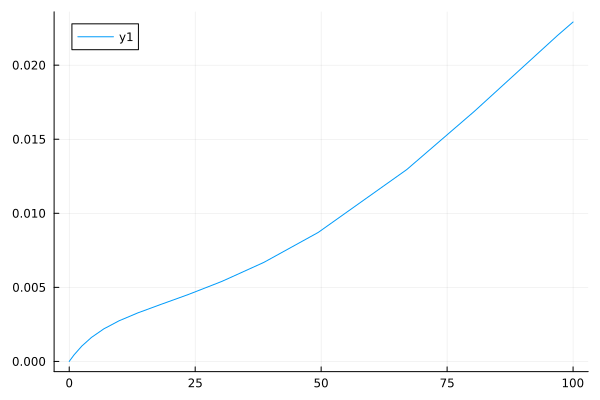

In [22]:
plot(sol.t, vaccine_demand)